## Car Image Classification Model

Importing libraries

In [1]:
import os
import random
import shutil
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder

Mounting Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip '/content/drive/MyDrive/car_body_type_df.zip'

Streaming output truncated to the last 5000 lines.
  inflating: car_body_type_df/stanford_cars_type/SUV/02508_Ford Expedition EL SUV 2009.jpg  
  inflating: car_body_type_df/stanford_cars_type/SUV/02509_BMW X6 SUV 2012.jpg  
  inflating: car_body_type_df/stanford_cars_type/SUV/02511_Hyundai Tucson SUV 2012.jpg  
  inflating: car_body_type_df/stanford_cars_type/SUV/02513_Land Rover Range Rover SUV 2012.jpg  
  inflating: car_body_type_df/stanford_cars_type/SUV/02514_Jeep Compass SUV 2012.jpg  
  inflating: car_body_type_df/stanford_cars_type/SUV/02522_Dodge Journey SUV 2012.jpg  
  inflating: car_body_type_df/stanford_cars_type/SUV/02531_Dodge Journey SUV 2012.jpg  
  inflating: car_body_type_df/stanford_cars_type/SUV/02542_Land Rover LR2 SUV 2012.jpg  
  inflating: car_body_type_df/stanford_cars_type/SUV/02555_Hyundai Veracruz SUV 2012.jpg  
  inflating: car_body_type_df/stanford_cars_type/SUV/02558_Jeep Grand Cherokee SUV 2012.jpg  
  inflating: car_body_type_df/stanford_cars_type/SUV

I tried modeling the data without Weighting the classes so this was my thought process


Classification Report & Confusion Matrix of the best model without balancing the data

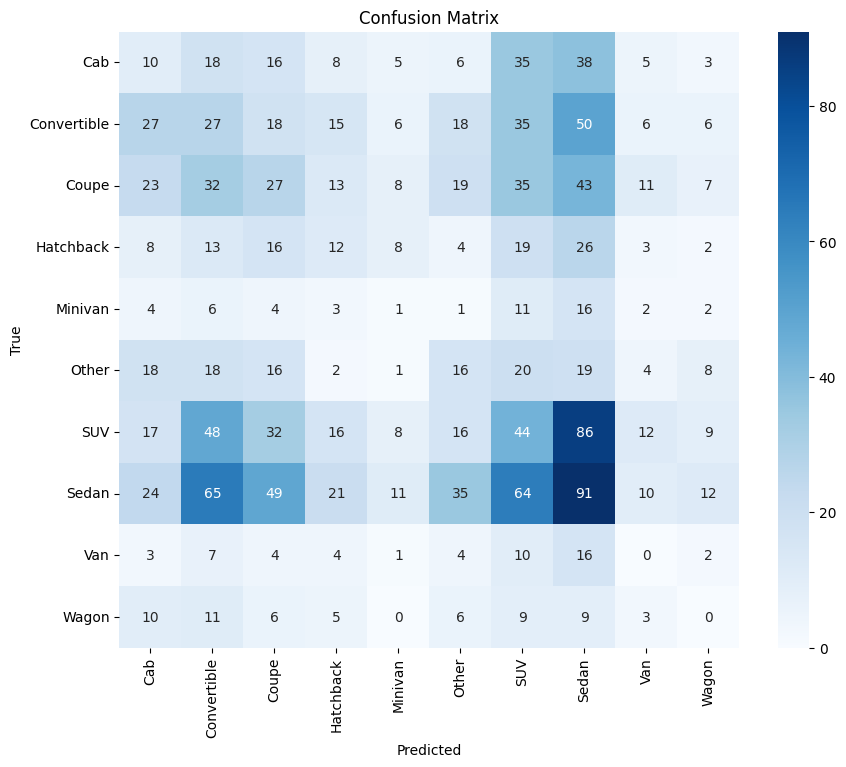

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
conf_matrix = confusion_matrix(val_true_labels, val_pred_labels)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Generate classification report
class_report = classification_report(val_true_labels, val_pred_labels, target_names=class_labels)

# Print the classification report
print(class_report)


              precision    recall  f1-score   support

         Cab       0.07      0.07      0.07       144
 Convertible       0.11      0.13      0.12       208
       Coupe       0.14      0.12      0.13       218
   Hatchback       0.12      0.11      0.11       111
     Minivan       0.02      0.02      0.02        50
       Other       0.13      0.13      0.13       122
         SUV       0.16      0.15      0.15       288
       Sedan       0.23      0.24      0.23       382
         Van       0.00      0.00      0.00        51
       Wagon       0.00      0.00      0.00        59

    accuracy                           0.14      1633
   macro avg       0.10      0.10      0.10      1633
weighted avg       0.14      0.14      0.14      1633



### Investigating & Handling classes imbalance

Rename 'Other' Folder/class to 'SuperCab'.

In [4]:
import os

# Define paths
base_path = '/content/car_body_type_df/stanford_cars_type'
old_class_name = 'Other'
new_class_name = 'SuperCab'

# Construct old and new paths
old_path = os.path.join(base_path, old_class_name)
new_path = os.path.join(base_path, new_class_name)

# Rename the folder
os.rename(old_path, new_path)


In [7]:
import shutil

# Rmove the now-empty .ipynb_notebook folder
# shutil.rmtree(os.path.join(base_path, '.ipynb_checkpoints'))

Data Imbalance after augmenting data on Roboflow

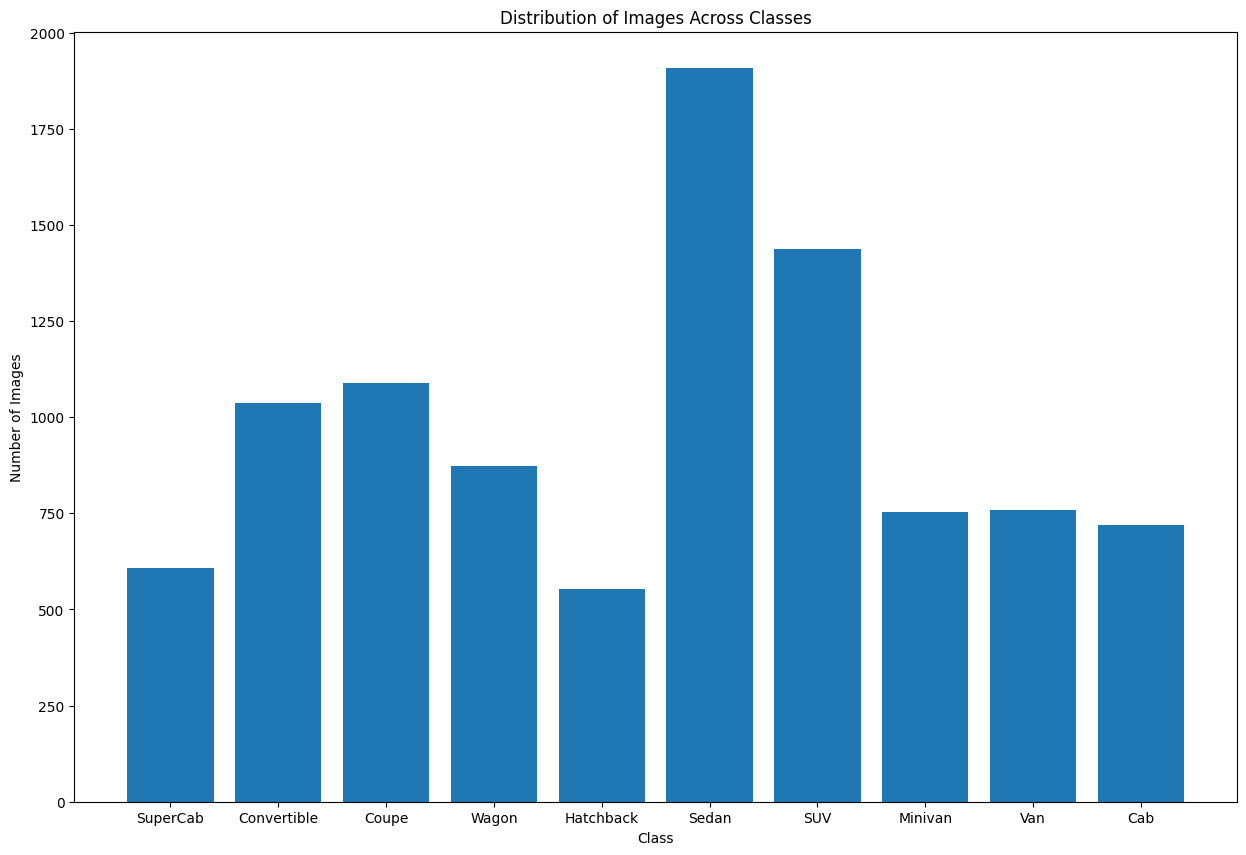

In [6]:
import os
import matplotlib.pyplot as plt

dataset_path = "/content/car_body_type_df/stanford_cars_type"

class_counts = {}
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        num_images = len(os.listdir(class_path))
        class_counts[class_name] = num_images

# Plotting
plt.figure(figsize=(15,10))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Distribution of Images Across Classes')
plt.show()


In [8]:
class_counts

{'SuperCab': 609,
 'Convertible': 1036,
 'Coupe': 1088,
 'Wagon': 873,
 'Hatchback': 554,
 'Sedan': 1907,
 'SUV': 1437,
 'Minivan': 753,
 'Van': 759,
 'Cab': 719}

After observing the data and reading the data_info.txt file about it I noticed very small classes like 'Van', 'Wagon' & 'Minivan'.\
So I decided to:\
1) Data Agmentation & Resample the 3 lowest classes on Roboflow.\
2) Try Focal Loss Function\
3) Weighting Classes in the model training\
*More approaches to mitigate huge data imbalance*:\
4) Try LearningRateScheduler\
5) Ensemble modeling

Splitting the data to train and validation datasets

In [9]:
# Define paths
data_dir = '/content/car_body_type_df/stanford_cars_type'                # dataset path
train_data_dir = '/content/car_body_type_df/train'                       # training data path
val_data_dir = '/content/car_body_type_df/validation'                    # validation data path

# Create train and validation directories if not exist
os.makedirs(train_data_dir, exist_ok=True)
os.makedirs(val_data_dir, exist_ok=True)

# Get class directories
class_directories = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

# Split data into train and validation
for class_dir in class_directories:
    class_images = os.listdir(os.path.join(data_dir, class_dir))
    train_images, val_images = train_test_split(class_images, test_size=0.2, random_state=42)

    # Move images to respective directories
    for img in train_images:
        src_path = os.path.join(data_dir, class_dir, img)
        dest_path = os.path.join(train_data_dir, class_dir, img)
        os.makedirs(os.path.join(train_data_dir, class_dir), exist_ok=True)
        shutil.move(src_path, dest_path)

    for img in val_images:
        src_path = os.path.join(data_dir, class_dir, img)
        dest_path = os.path.join(val_data_dir, class_dir, img)
        os.makedirs(os.path.join(val_data_dir, class_dir), exist_ok=True)
        shutil.move(src_path, dest_path)

Data Augmentation and ImageDataGenerator

In [10]:
val_data_dir

'/content/car_body_type_df/validation'

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_data_dir = '/content/car_body_type_df/train'                       # training data path
val_data_dir = '/content/car_body_type_df/validation'                    # validation data path

# Set the image size and batch size for further use
img_size = (224, 224)
batch_size = 16

# Create data generators with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    # rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode='nearest'
)

# Train generator
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    # subset='training'

)

# Create a data generator for validation
val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    val_data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    # subset='validation'
)


Found 9398 images belonging to 10 classes.
Found 2704 images belonging to 10 classes.


### Calculating Class Weights

In [12]:
class_counts

{'SuperCab': 609,
 'Convertible': 1036,
 'Coupe': 1088,
 'Wagon': 873,
 'Hatchback': 554,
 'Sedan': 1907,
 'SUV': 1437,
 'Minivan': 753,
 'Van': 759,
 'Cab': 719}

In [13]:
# Calculate class weights
total_samples = sum(class_counts.values())
class_weights = {class_label: total_samples / (len(class_counts) * count)
for class_label, count in class_counts.items()}

class_weights

{'SuperCab': 1.5985221674876848,
 'Convertible': 0.9396718146718147,
 'Coupe': 0.8947610294117647,
 'Wagon': 1.1151202749140894,
 'Hatchback': 1.7572202166064983,
 'Sedan': 0.510487676979549,
 'SUV': 0.6774530271398748,
 'Minivan': 1.292828685258964,
 'Van': 1.2826086956521738,
 'Cab': 1.3539638386648123}

In [14]:
import numpy as np

# Get class counts for both generators
train_class_counts = np.unique(train_generator.classes, return_counts=True)
val_class_counts = np.unique(val_generator.classes, return_counts=True)

# Get class names from the generator's class_indices
class_names = list(train_generator.class_indices.keys())

In [15]:
# Convert class names to indices
class_indices = {class_name: i for i, class_name in enumerate(class_names)}

# Create the class weight array
class_weights_array = [class_weights[class_name] for class_name in class_names]

# To use in model.fit() call
class_weights_array

[1.3539638386648123,
 0.9396718146718147,
 0.8947610294117647,
 1.7572202166064983,
 1.292828685258964,
 0.6774530271398748,
 0.510487676979549,
 1.5985221674876848,
 1.2826086956521738,
 1.1151202749140894]

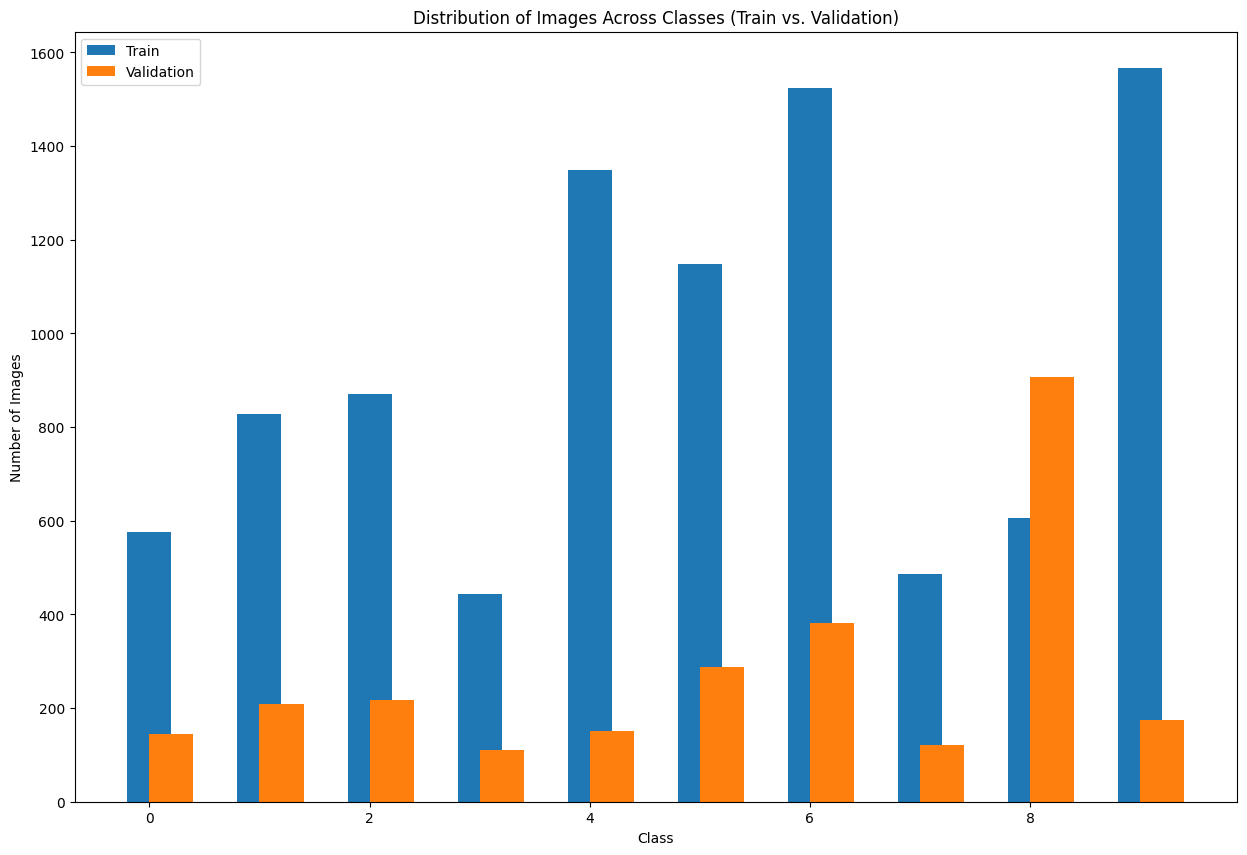

In [16]:
# Plotting
plt.figure(figsize=(15, 10))

plt.bar(train_class_counts[0], train_class_counts[1], width=0.4, align='center', label='Train')
plt.bar(val_class_counts[0], val_class_counts[1], width=0.4, align='edge', label='Validation')

plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Distribution of Images Across Classes (Train vs. Validation)')
plt.legend()
plt.show()

In [17]:
train_class_counts

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32),
 array([ 575,  828,  870,  443, 1349, 1149, 1525,  487,  606, 1566]))

In [18]:
val_class_counts

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32),
 array([144, 208, 218, 111, 151, 288, 382, 122, 906, 174]))

### Transfer Learning using AlexNet & Pre-trained VGG19

AlexNet

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.applications import VGG19

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Define the AlexNet model
def alexnet_model(input_shape, num_classes):
    model = Sequential()

    # Layer 1
    model.add(Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

    # Layer 2
    model.add(Conv2D(256, (5, 5), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

    # Layer 3
    model.add(Conv2D(384, (3, 3), padding='same', activation='relu'))

    # Layer 4
    model.add(Conv2D(384, (3, 3), padding='same', activation='relu'))

    # Layer 5
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

    # Flatten
    model.add(Flatten())

    # Layer 6
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

    # Layer 7
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

    # Output layer
    model.add(Dense(num_classes, activation='softmax'))

    return model


input_shape = (224, 224, 3)
num_classes = 9

alexnet = alexnet_model(input_shape, num_classes)

# Compile the model
alexnet.compile(optimizer=Adam(learning_rate=0.0001), loss=tf.keras.losses.CategoricalFocalCrossentropy(),
              metrics=['accuracy'])

# Display the model summary
alexnet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 54, 54, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2  (None, 26, 26, 96)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 12, 12, 256)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 384)       885120    
                                                                 
 conv2d_3 (Conv2D)           (None, 12, 12, 384)       1

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler

# Define a simple learning rate schedule
def lr_schedule(epoch):
    if epoch < 50:
        return 0.0001
    elif epoch < 80:
        return 0.00001
    else:
        return 0.000001

# Create a LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
alexnet.fit(train_generator, epochs=200, validation_data=val_generator,
          class_weight=dict(enumerate(class_weights_array)), callbacks=
           [early_stopping, lr_scheduler])

alexnet.save('AlexNet_best_car_classification_model.h5')


Epoch 1/100
407/407 [==============================] - 142s 309ms/step - loss: 0.4217 - accuracy: 0.1630 - val_loss: 0.4226 - val_accuracy: 0.1629 - lr: 1.0000e-04
Epoch 2/100
407/407 [==============================] - 121s 297ms/step - loss: 0.4143 - accuracy: 0.1693 - val_loss: 0.4195 - val_accuracy: 0.1739 - lr: 1.0000e-04
Epoch 3/100
407/407 [==============================] - 123s 304ms/step - loss: 0.4125 - accuracy: 0.1700 - val_loss: 0.4242 - val_accuracy: 0.1629 - lr: 1.0000e-04
Epoch 4/100
407/407 [==============================] - 128s 315ms/step - loss: 0.4101 - accuracy: 0.1699 - val_loss: 0.4232 - val_accuracy: 0.1782 - lr: 1.0000e-04
Epoch 5/100
407/407 [==============================] - 129s 316ms/step - loss: 0.4092 - accuracy: 0.1683 - val_loss: 0.4144 - val_accuracy: 0.1776 - lr: 1.0000e-04
Epoch 6/100
407/407 [==============================] - 129s 316ms/step - loss: 0.4069 - accuracy: 0.1688 - val_loss: 0.4252 - val_accuracy: 0.1672 - lr: 1.0000e-04
Epoch 7/100
407/

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


VGG19 Model

In [ ]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler


# Define a simple learning rate schedule
def lr_schedule(epoch):
    if epoch < 50:
        return 0.0001
    elif epoch < 80:
        return 0.00001
    else:
        return 0.000001

# Create a LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

# Load the pre-trained VGG16 model
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freezing the layers up to the last block
freeze_up_to = 17
for layer in base_model.layers[:freeze_up_to]:
    layer.trainable = False

# Create your model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu',kernel_regularizer='L1'),
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu',kernel_regularizer='L1'),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu',kernel_regularizer='L1'),
    layers.BatchNormalization(),
    layers.Dense(len(class_names), activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss=tf.keras.losses.CategoricalFocalCrossentropy(),
              metrics=['accuracy'])

80134624/80134624 [==============================] - 5s 0us/step


In [ ]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
model.fit(train_generator, epochs=100, validation_data=val_generator,
          class_weight=dict(enumerate(class_weights_array)), callbacks=[early_stopping,lr_scheduler])

model.save('VGG19_best_car_classification_model.h5')

Epoch 1/100
487/487 [==============================] - 180s 334ms/step - loss: 108.9795 - accuracy: 0.2207 - val_loss: 53.4755 - val_accuracy: 0.2196 - lr: 1.0000e-04
Epoch 2/100
487/487 [==============================] - 172s 353ms/step - loss: 26.8009 - accuracy: 0.4007 - val_loss: 11.5339 - val_accuracy: 0.3905 - lr: 1.0000e-04
Epoch 3/100
487/487 [==============================] - 156s 321ms/step - loss: 5.9821 - accuracy: 0.5703 - val_loss: 2.6172 - val_accuracy: 0.6147 - lr: 1.0000e-04
Epoch 4/100
487/487 [==============================] - 156s 321ms/step - loss: 1.4876 - accuracy: 0.6226 - val_loss: 0.8750 - val_accuracy: 0.5023 - lr: 1.0000e-04
Epoch 5/100
487/487 [==============================] - 151s 309ms/step - loss: 0.6064 - accuracy: 0.6398 - val_loss: 0.4855 - val_accuracy: 0.6049 - lr: 1.0000e-04
Epoch 6/100
487/487 [==============================] - 150s 307ms/step - loss: 0.3934 - accuracy: 0.6830 - val_loss: 0.4441 - val_accuracy: 0.4392 - lr: 1.0000e-04
Epoch 7/100

ResNet50

In [23]:
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications import ResNet50


# Define a simple learning rate schedule
def lr_schedule(epoch):
    if epoch < 50:
        return 0.0001
    elif epoch < 80:
        return 0.00001
    else:
        return 0.000001

# Create a LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

# Load the pre-trained ResNet50 model
base_model = ResNet50(input_shape = (224,224,3), include_top = False, weights = 'imagenet')

# Freezing the layers up to the last block
freeze_up_to =
for layer in base_model.layers[:freeze_up_to]:
    layer.trainable = False

base_model.summary()

# Create your model
res_model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(1024, activation='relu',kernel_regularizer='L1'),
    layers.Dropout(0.2),
    # layers.Dense(128, activation='relu',kernel_regularizer='L1'),
    # layers.BatchNormalization(),
    layers.Dense(len(class_names), activation='softmax')
])

# Compile the model
res_model.compile(optimizer=RMSprop(learning_rate=0.0001), loss=tf.keras.losses.CategoricalFocalCrossentropy(),
              metrics=['accuracy'])


early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
res_model.fit(train_generator, epochs=100, validation_data=val_generator,
          class_weight=dict(enumerate(class_weights_array)), callbacks=[early_stopping,lr_scheduler])

# Save the best model weights
res_model.save('ResNet50_best_car_classification_model.h5')

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_4[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

Exception ignored in: <function _xla_gc_callback at 0x7f3ad9d06f80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 101, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


Epoch 1/100
588/588 [==============================] - 230s 358ms/step - loss: 184.8638 - accuracy: 0.1621 - val_loss: 51.8199 - val_accuracy: 0.1058 - lr: 1.0000e-04
Epoch 2/100
588/588 [==============================] - 204s 346ms/step - loss: 51.7656 - accuracy: 0.1982 - val_loss: 51.7131 - val_accuracy: 0.0965 - lr: 1.0000e-04
Epoch 3/100
588/588 [==============================] - 201s 342ms/step - loss: 51.7032 - accuracy: 0.2342 - val_loss: 51.7550 - val_accuracy: 0.1198 - lr: 1.0000e-04
Epoch 4/100
588/588 [==============================] - 200s 340ms/step - loss: 51.6625 - accuracy: 0.2969 - val_loss: 51.8093 - val_accuracy: 0.1542 - lr: 1.0000e-04
Epoch 5/100
588/588 [==============================] - 197s 334ms/step - loss: 51.6195 - accuracy: 0.3491 - val_loss: 51.5963 - val_accuracy: 0.4253 - lr: 1.0000e-04
Epoch 6/100
588/588 [==============================] - 199s 338ms/step - loss: 51.5811 - accuracy: 0.3868 - val_loss: 51.5479 - val_accuracy: 0.4700 - lr: 1.0000e-04
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


AlexNet

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.applications import VGG19

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Define the AlexNet model
def alexnet_model(input_shape, num_classes):
    model = Sequential()

    # Layer 1
    model.add(Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

    # Layer 2
    model.add(Conv2D(256, (5, 5), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

    # Layer 3
    model.add(Conv2D(384, (3, 3), padding='same', activation='relu'))

    # Layer 4
    model.add(Conv2D(384, (3, 3), padding='same', activation='relu'))

    # Layer 5
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

    # Flatten
    model.add(Flatten())

    # Layer 6
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

    # Layer 7
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

    # Output layer
    model.add(Dense(num_classes, activation='softmax'))

    return model


input_shape = (224, 224, 3)
num_classes = 9

alexnet = alexnet_model(input_shape, num_classes)

# Compile the model
alexnet.compile(optimizer=Adam(learning_rate=0.0001), loss=tf.keras.losses.CategoricalFocalCrossentropy(),
              metrics=['accuracy'])

# Display the model summary
alexnet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 54, 54, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2  (None, 26, 26, 96)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 12, 12, 256)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 384)       885120    
                                                                 
 conv2d_3 (Conv2D)           (None, 12, 12, 384)       1

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler

# Define a simple learning rate schedule
def lr_schedule(epoch):
    if epoch < 50:
        return 0.0001
    elif epoch < 80:
        return 0.00001
    else:
        return 0.000001

# Create a LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
alexnet.fit(train_generator, epochs=200, validation_data=val_generator,
          class_weight=dict(enumerate(class_weights_array)), callbacks=
           [early_stopping, lr_scheduler])

alexnet.save('AlexNet_best_car_classification_model.h5')


Epoch 1/100
407/407 [==============================] - 142s 309ms/step - loss: 0.4217 - accuracy: 0.1630 - val_loss: 0.4226 - val_accuracy: 0.1629 - lr: 1.0000e-04
Epoch 2/100
407/407 [==============================] - 121s 297ms/step - loss: 0.4143 - accuracy: 0.1693 - val_loss: 0.4195 - val_accuracy: 0.1739 - lr: 1.0000e-04
Epoch 3/100
407/407 [==============================] - 123s 304ms/step - loss: 0.4125 - accuracy: 0.1700 - val_loss: 0.4242 - val_accuracy: 0.1629 - lr: 1.0000e-04
Epoch 4/100
407/407 [==============================] - 128s 315ms/step - loss: 0.4101 - accuracy: 0.1699 - val_loss: 0.4232 - val_accuracy: 0.1782 - lr: 1.0000e-04
Epoch 5/100
407/407 [==============================] - 129s 316ms/step - loss: 0.4092 - accuracy: 0.1683 - val_loss: 0.4144 - val_accuracy: 0.1776 - lr: 1.0000e-04
Epoch 6/100
407/407 [==============================] - 129s 316ms/step - loss: 0.4069 - accuracy: 0.1688 - val_loss: 0.4252 - val_accuracy: 0.1672 - lr: 1.0000e-04
Epoch 7/100
407/

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Ensemble Modeling

In [ ]:
model1 = alexnet
model2 = model

preds1 = model1.predict(val_generator)
preds2 = model2.predict(val_generator)

ensemble_preds = (preds1 + preds2) / 2  # simple average


Evaluate
Predict, Confusion Matrix Heatmap & Classification Report

In [ ]:
import numpy as np

class_labels = train_generator.classes_

# Generate predictions for the validation set
val_predictions = model.predict(val_generator)

# Convert predictions to class labels
val_pred_labels = [np.argmax(pred) for pred in val_predictions]

# Get true labels from the generator
val_true_labels = val_generator.classes

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
conf_matrix = confusion_matrix(val_true_labels, val_pred_labels)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import classification_report

# Generate classification report
class_report = classification_report(val_true_labels, val_pred_labels, target_names=class_labels)

# Print the classification report
print(class_report)